## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 18.2 MB/s 
     |████████████████████████████████| 212 kB 46.9 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
dataset=nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [ ]:
tweets, labels = get_tweet(train)

In [ ]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
# All the words in the tweet needs to be converted numbers to be used in our neural network and tokenizer does that for us.
# We can set a limit to how many frequently used words are tokenized and rest less common words are ignored. 

In [ ]:
#We give those words a common token known as unknown token.
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>') #Anything thats not present in most frequently used 10000 works will be given token UNK
tokenizer.fit_on_texts(tweets) #creating mapping between the texts and the tokens

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

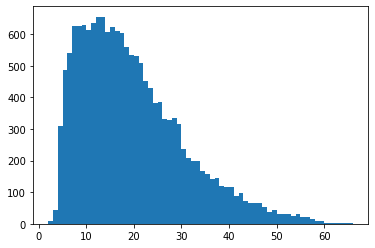

In [ ]:
#we need to do padding and trincation the sequence as length of each tweet is not the same
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [ ]:
maxlen = 50 #any tweet over 50 words will be truncated and chopped off
# and any tweet with lesser length than a given value will be padded
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen) #post means truncating will happen at the end of the sequence
  # and if length is lesser than 50 then last 50-n elements will be padded
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes = set(labels) #we already have labels from the training set we are just going to create a set out of that
print(classes)

{'sadness', 'joy', 'anger', 'surprise', 'fear', 'love'}


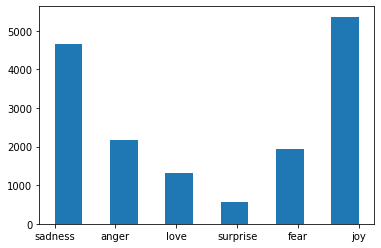

In [ ]:
plt.hist(labels, bins=11)
plt.show() # shows the number of example for each classes

In [ ]:
# we have many examples for saddness and joy but we dont have as many examples for rest of the classes
#this is called a class imbalence problem, but we wont focus on that in our project.
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [ ]:
class_to_index

{'anger': 2, 'fear': 4, 'joy': 1, 'love': 5, 'sadness': 0, 'surprise': 3}

In [ ]:
index_to_class

{0: 'sadness', 1: 'joy', 2: 'anger', 3: 'surprise', 4: 'fear', 5: 'love'}

In [ ]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels]) #We will pass the labels as text values and we will get the labels back as numeric representation

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
# we are going to use the seqential class in keras to make the model
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)), #bidirectional means context from LSTM can go from both left to right and right to left
        # lstm layer will give an output in every time sequence and it will be sent to next bidirectional lstm layer
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy', # for multi class regression we can use cross categorical entropy
    optimizer='adam',
    metrics=['accuracy']

)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [ ]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 7s 13ms/step - loss: 0.0487 - accuracy: 0.9847 - val_loss: 0.4653 - val_accuracy: 0.8930
Epoch 2/20
500/500 [==============================] - 6s 13ms/step - loss: 0.0449 - accuracy: 0.9861 - val_loss: 0.4760 - val_accuracy: 0.8905
Epoch 3/20
500/500 [==============================] - 7s 13ms/step - loss: 0.0493 - accuracy: 0.9841 - val_loss: 0.4364 - val_accuracy: 0.8965
Epoch 4/20
500/500 [==============================] - 6s 13ms/step - loss: 0.0359 - accuracy: 0.9876 - val_loss: 0.4466 - val_accuracy: 0.8970
Epoch 5/20
500/500 [==============================] - 6s 13ms/step - loss: 0.0345 - accuracy: 0.9893 - val_loss: 0.4557 - val_accuracy: 0.8895
Epoch 6/20
500/500 [==============================] - 6s 13ms/step - loss: 0.0273 - accuracy: 0.9908 - val_loss: 0.4419 - val_accuracy: 0.9015
Epoch 7/20
500/500 [==============================] - 6s 13ms/step - loss: 0.0296 - accuracy: 0.9911 - val_loss: 0.4865 - val_accuracy: 0.8950

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

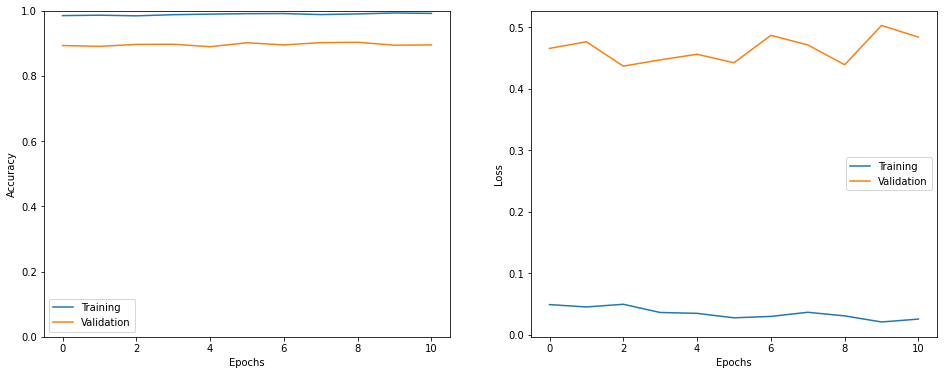

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_= model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.5291 - accuracy: 0.8835


In [ ]:
i = random.randint(0, len(test_labels) - 1)
print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])
p= model.predict(np.expand_dims(test_seq[i], axis=0))[0] #Expand input is to make text input appropriate shape
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted emotion:', pred_class)

Sentence: i dont remember how january was like last year thats why i need a real diary but this one is feeling bitter dark and boring
Emotion: anger
Predicted emotion: anger


In [ ]:
preds = model.predict(test_seq)
pclasses = np.argmax(preds, axis=1)

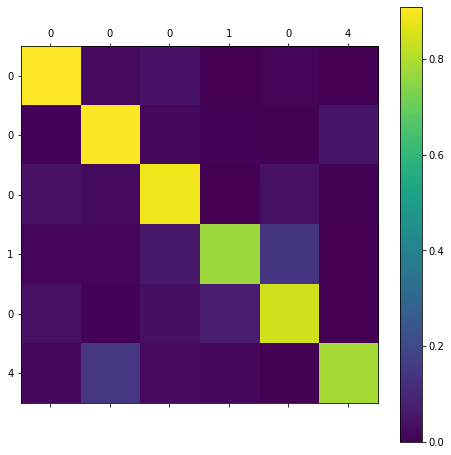

In [ ]:
show_confusion_matrix(test_labels, pclasses, list(classes))